In [1]:
# STEP 2 — Load the A/B dataset and do quick sanity checks
# - Uses ab_data.csv as the main file
# - Shows shape, columns, sample rows
# - Verifies required columns exist (user_id, timestamp, group, converted)
# - Quick look at group allocation and converted values

from pathlib import Path
import pandas as pd

# Resolve project paths (notebook is inside /notebooks)
NB = Path.cwd()
BASE = NB.parent if NB.name.lower() == "notebooks" else NB
DATA = BASE / "data"

ab_path = DATA / "ab_data.csv"
countries_path = DATA / "countries.csv"  # optional side file

print("Base:", BASE)
print("Reading:", ab_path)

# Load (handle common encodings)
df = pd.read_csv(ab_path, encoding="utf-8", low_memory=False)

print("\nRows, Cols:", df.shape)
print("\nColumns:", list(df.columns))

print("\nSample (top 5):")
display(df.head())

# Normalize obvious column names for the rest of the project
# (only in-memory for now; we won't write anything yet)
rename_map = {}
cols_lower = [c.lower().strip() for c in df.columns]
df.columns = cols_lower

# Try to standardize typical variants to our required schema
if "variant" in df.columns and "group" not in df.columns:
    rename_map["variant"] = "group"
if "treatment" in df.columns and "group" not in df.columns:
    rename_map["treatment"] = "group"
if "purchased" in df.columns and "converted" not in df.columns:
    rename_map["purchased"] = "converted"
if "purchase" in df.columns and "converted" not in df.columns:
    rename_map["purchase"] = "converted"
if "event_time" in df.columns and "timestamp" not in df.columns:
    rename_map["event_time"] = "timestamp"
if "user" in df.columns and "user_id" not in df.columns:
    rename_map["user"] = "user_id"
if rename_map:
    df = df.rename(columns=rename_map)

required = {"user_id","timestamp","group","converted"}
missing = required - set(df.columns)
print("\nRequired columns check:")
print("  Required:", required)
print("  Missing :", missing if missing else "None ✅")

# If timestamp exists, try to parse
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Basic stats for the two key fields
if "group" in df.columns:
    df["group"] = df["group"].astype(str).str.upper()
    print("\nGroup allocation (top 5):")
    print(df["group"].value_counts().head())

if "converted" in df.columns:
    # some datasets store as 0/1 ints, some as booleans, some as strings
    try:
        df["converted"] = pd.to_numeric(df["converted"], errors="coerce").fillna(0).astype(int)
    except Exception:
        pass
    print("\nConverted value counts:")
    print(df["converted"].value_counts(dropna=False))

# Null overview for required columns (if present)
print("\nNull overview for required columns (if present):")
for c in required:
    if c in df.columns:
        print(f"  {c}: {df[c].isna().sum()} nulls")

Base: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project
Reading: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\data\ab_data.csv

Rows, Cols: (294480, 5)

Columns: ['user_id', 'timestamp', 'group', 'landing_page', 'converted']

Sample (top 5):


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1



Required columns check:
  Required: {'user_id', 'timestamp', 'converted', 'group'}
  Missing : None ✅

Group allocation (top 5):
TREATMENT    147278
CONTROL      147202
Name: group, dtype: int64

Converted value counts:
0    259243
1     35237
Name: converted, dtype: int64

Null overview for required columns (if present):
  user_id: 0 nulls
  timestamp: 177213 nulls
  converted: 0 nulls
  group: 0 nulls


In [2]:
# STEP 3 — Clean and prepare dataset for analysis
# What this cell does:
# - Normalizes group labels
# - Ensures converted is 0/1 integer
# - Drops duplicate rows
# - Prints group distribution and conversion counts

# 1) Normalize group values
df['group'] = df['group'].astype(str).str.upper().replace({
    'CONTROL': 'A',
    'TREATMENT': 'B'
})

# 2) Ensure converted is 0/1 integer
df['converted'] = pd.to_numeric(df['converted'], errors='coerce').fillna(0).astype(int)

# 3) Drop duplicate rows (safety check)
before = df.shape[0]
df = df.drop_duplicates(subset=['user_id','timestamp','group'])
after = df.shape[0]

print(f"Rows before dedupe: {before}, after dedupe: {after}")

# 4) Group allocation summary
print("\nGroup counts:")
print(df['group'].value_counts(normalize=True).round(3))

# 5) Conversion summary
print("\nConversion counts (0 = not converted, 1 = converted):")
print(df['converted'].value_counts(normalize=True).round(3))

Rows before dedupe: 294480, after dedupe: 293775

Group counts:
B    0.5
A    0.5
Name: group, dtype: float64

Conversion counts (0 = not converted, 1 = converted):
0    0.88
1    0.12
Name: converted, dtype: float64


In [3]:
# STEP 4 — Hypothesis + A/B Test
# Hypothesis (business terms):
# H0 (null): Conversion rate for A = Conversion rate for B
# H1 (alt): Conversion rate for B > Conversion rate for A (one-sided)

import math
from math import sqrt
from scipy.stats import norm

# Split groups
A = df[df['group'] == 'A']
B = df[df['group'] == 'B']

nA, nB = len(A), len(B)
pA, pB = A['converted'].mean(), B['converted'].mean()

# Two-proportion z-test
p_pool = (A['converted'].sum() + B['converted'].sum()) / (nA + nB)
se = math.sqrt(p_pool * (1 - p_pool) * (1/nA + 1/nB))
z = (pB - pA) / se
p_value = 1 - norm.cdf(z)   # one-sided test

# 95% CI for difference (Wald)
diff = pB - pA
z_crit = norm.ppf(0.975)
ci_low = diff - z_crit * se
ci_high = diff + z_crit * se
lift_rel = (diff / pA) * 100

print("=== A/B Test Results ===")
print(f"Group A size: {nA}, Conversion: {pA:.4f}")
print(f"Group B size: {nB}, Conversion: {pB:.4f}")
print(f"Absolute diff (B - A): {diff:.4f}")
print(f"Relative lift: {lift_rel:.2f}%")
print(f"Z-score: {z:.3f}")
print(f"P-value (one-sided): {p_value:.6f}")
print(f"95% CI for (pB - pA): [{ci_low:.4f}, {ci_high:.4f}]")

=== A/B Test Results ===
Group A size: 146843, Conversion: 0.1204
Group B size: 146932, Conversion: 0.1189
Absolute diff (B - A): -0.0015
Relative lift: -1.24%
Z-score: -1.243
P-value (one-sided): 0.893078
95% CI for (pB - pA): [-0.0038, 0.0009]


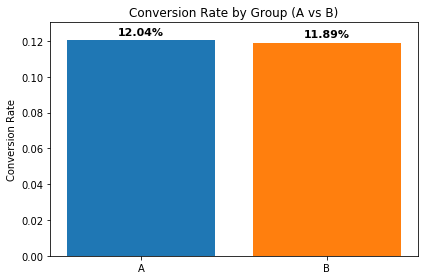

Clean chart saved to: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\conversion_rate_by_group_clean.png


In [9]:
# STEP 5 — Conversion Rate by Group chart

import matplotlib.pyplot as plt

conv_rates = df.groupby('group')['converted'].mean().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(conv_rates.index, conv_rates.values, color=['#1f77b4','#ff7f0e'])

plt.title("Conversion Rate by Group (A vs B)")
plt.ylabel("Conversion Rate")

# Add labels above bars with padding so they don't cut off
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             y + 0.002,                 # more vertical padding
             f"{y:.2%}",                # format as %
             ha='center', va='bottom', fontsize=11, weight='bold')

# Extend y-axis limit a bit so text is inside the frame
plt.ylim(0, conv_rates.max() + 0.01)

# Save to /image
img_path = IMAGES / "conversion_rate_by_group_clean.png"
plt.tight_layout()
plt.savefig(img_path, dpi=150)
plt.show()

print("Clean chart saved to:", img_path)

In [10]:
# STEP 6 — Chi-Square Test of Independence
# Purpose:
# - Tests whether conversion outcome (0/1) is independent of group (A vs B)
# - Another way to validate the relationship between group assignment and conversion

import scipy.stats as stats
import pandas as pd

# Build contingency table
contingency = pd.crosstab(df['group'], df['converted'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("=== Chi-Square Test ===")
print("Contingency Table (Observed):")
print(contingency)

print(f"\nChi2 Statistic: {chi2:.3f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.6f}")

print("\nExpected Frequencies:")
print(expected)

=== Chi-Square Test ===
Contingency Table (Observed):
converted       0      1
group                   
A          129168  17675
B          129465  17467

Chi2 Statistic: 1.531
Degrees of Freedom: 1
P-value: 0.215945

Expected Frequencies:
[[129277.32318611  17565.67681389]
 [129355.67681389  17576.32318611]]


Funnel by landing_page


,exposed,converted,conv_rate
landing_page,,,
new_page,146891,17448,0.118782
old_page,146884,17694,0.120462


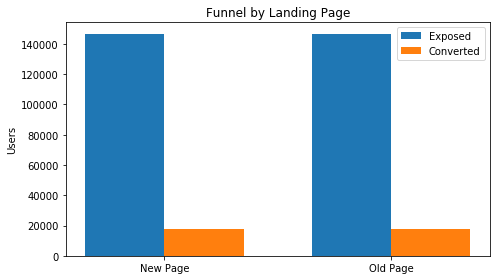

Saved: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\funnel_by_landing_page.png


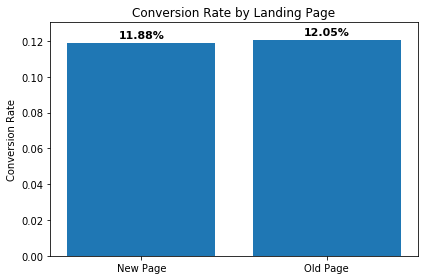

Saved: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\conversion_rate_by_landing_page.png

Funnel by group


,exposed,converted,conv_rate
group,,,
A,146843,17675,0.120367
B,146932,17467,0.118878


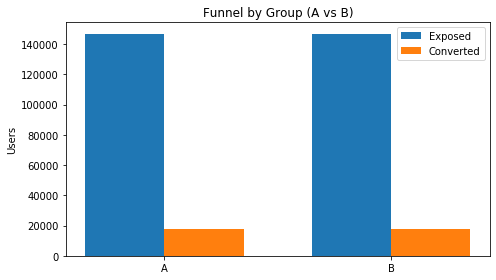

Saved: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\funnel_by_group.png


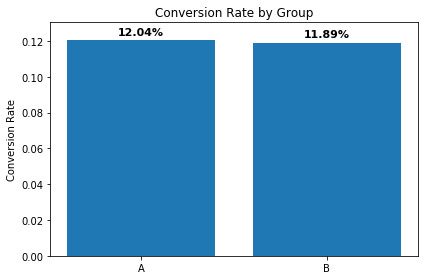

Saved: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\conversion_rate_by_group_kpi.png


In [12]:
# STEP 7 — Funnel simulation (landing_page → conversion) + clean charts

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Paths
NB = Path.cwd()
BASE = NB.parent if NB.name.lower() == "notebooks" else NB
IMAGES = BASE / "image"
IMAGES.mkdir(parents=True, exist_ok=True)

# ---------- Funnel by landing_page ----------
# Older-pandas friendly aggregation (no named-agg)
f_lp = (
    df.groupby('landing_page')[['user_id','converted']]
      .agg({'user_id':'count', 'converted':'sum'})
      .rename(columns={'user_id':'exposed'})
      .assign(conv_rate=lambda x: x['converted'] / x['exposed'])
      .sort_index()
)
print("Funnel by landing_page")
display(f_lp)

# Plot 1: Exposed vs Converted by page
plt.figure(figsize=(7,4))
width = 0.35
x = range(len(f_lp))
labels = [s.replace('_',' ').title() for s in f_lp.index]

plt.bar([i - width/2 for i in x], f_lp['exposed'], width, label='Exposed')
plt.bar([i + width/2 for i in x], f_lp['converted'], width, label='Converted')
plt.xticks(list(x), labels)
plt.title("Funnel by Landing Page")
plt.ylabel("Users")
plt.legend()
out1 = IMAGES / "funnel_by_landing_page.png"
plt.tight_layout(); plt.savefig(out1, dpi=150); plt.show()
print("Saved:", out1)

# Plot 2: Conversion rate by page
plt.figure(figsize=(6,4))
bars = plt.bar(labels, f_lp['conv_rate'])
plt.title("Conversion Rate by Landing Page")
plt.ylabel("Conversion Rate")
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y + 0.002, f"{y:.2%}",
             ha='center', va='bottom', fontsize=11, weight='bold')
plt.ylim(0, f_lp['conv_rate'].max() + 0.01)
out2 = IMAGES / "conversion_rate_by_landing_page.png"
plt.tight_layout(); plt.savefig(out2, dpi=150); plt.show()
print("Saved:", out2)

# ---------- Funnel by A/B group ----------
f_grp = (
    df.groupby('group')[['user_id','converted']]
      .agg({'user_id':'count', 'converted':'sum'})
      .rename(columns={'user_id':'exposed'})
      .assign(conv_rate=lambda x: x['converted'] / x['exposed'])
      .sort_index()
)
print("\nFunnel by group")
display(f_grp)

# Plot 3: Exposed vs Converted by group
plt.figure(figsize=(7,4))
x = range(len(f_grp))
plt.bar([i - width/2 for i in x], f_grp['exposed'], width, label='Exposed')
plt.bar([i + width/2 for i in x], f_grp['converted'], width, label='Converted')
plt.xticks(list(x), list(f_grp.index))
plt.title("Funnel by Group (A vs B)")
plt.ylabel("Users")
plt.legend()
out3 = IMAGES / "funnel_by_group.png"
plt.tight_layout(); plt.savefig(out3, dpi=150); plt.show()
print("Saved:", out3)

# Plot 4: Conversion rate by group
plt.figure(figsize=(6,4))
bars = plt.bar(list(f_grp.index), f_grp['conv_rate'])
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y + 0.002, f"{y:.2%}",
             ha='center', va='bottom', fontsize=11, weight='bold')
plt.ylim(0, f_grp['conv_rate'].max() + 0.01)
out4 = IMAGES / "conversion_rate_by_group_kpi.png"
plt.tight_layout(); plt.savefig(out4, dpi=150); plt.show()
print("Saved:", out4)

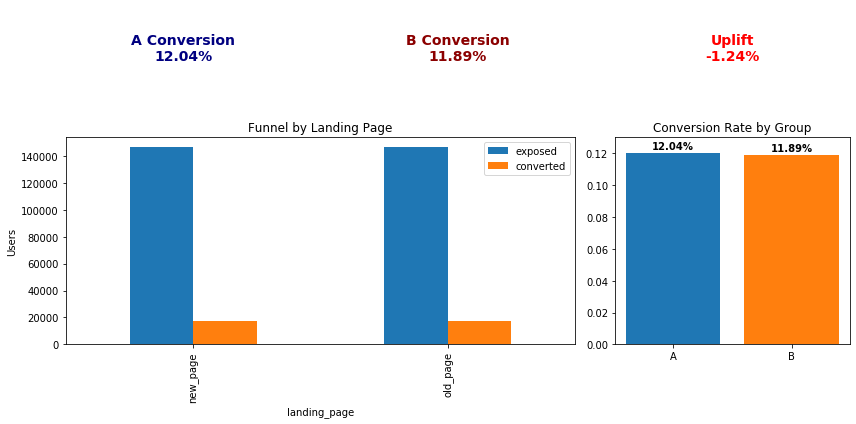

Dashboard saved to: C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\image\dashboard_mock.png


In [13]:
# STEP 8 — Simulated Power BI / Tableau style dashboard in Python
import matplotlib.pyplot as plt

# Calculate summary metrics
conv_A = f_grp.loc['A','conv_rate']
conv_B = f_grp.loc['B','conv_rate']
uplift = (conv_B - conv_A) / conv_A * 100

# Create dashboard canvas
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 3, height_ratios=[1,2])

# --- KPI Cards ---
ax1 = fig.add_subplot(gs[0,0])
ax1.axis("off")
ax1.text(0.5, 0.6, f"A Conversion\n{conv_A:.2%}", ha='center', va='center', fontsize=14, weight='bold', color='navy')

ax2 = fig.add_subplot(gs[0,1])
ax2.axis("off")
ax2.text(0.5, 0.6, f"B Conversion\n{conv_B:.2%}", ha='center', va='center', fontsize=14, weight='bold', color='darkred')

ax3 = fig.add_subplot(gs[0,2])
ax3.axis("off")
ax3.text(0.5, 0.6, f"Uplift\n{uplift:.2f}%", ha='center', va='center', fontsize=14, weight='bold', color='green' if uplift>0 else 'red')

# --- Funnel by landing_page ---
ax4 = fig.add_subplot(gs[1,0:2])
f_lp[['exposed','converted']].plot(kind='bar', ax=ax4, color=['#1f77b4','#ff7f0e'])
ax4.set_title("Funnel by Landing Page")
ax4.set_ylabel("Users")
ax4.legend()

# --- Conversion rates by group ---
ax5 = fig.add_subplot(gs[1,2])
bars = ax5.bar(f_grp.index, f_grp['conv_rate'], color=['#1f77b4','#ff7f0e'])
ax5.set_title("Conversion Rate by Group")
ax5.set_ylim(0, max(f_grp['conv_rate'])+0.01)
for b in bars:
    y = b.get_height()
    ax5.text(b.get_x()+b.get_width()/2, y+0.001, f"{y:.2%}", ha='center', va='bottom', fontsize=10, weight='bold')

# Save simulated dashboard
dash_path = IMAGES / "dashboard_mock.png"
plt.tight_layout()
plt.savefig(dash_path, dpi=150)
plt.show()

print("Dashboard saved to:", dash_path)

In [14]:
# STEP 9 — Export metrics summary (CSV + JSON)

import json
import pandas as pd

# Prepare summary dictionary with key metrics
summary = {
    "Group A": {
        "n": int(f_grp.loc['A','exposed']),
        "conversions": int(f_grp.loc['A','converted']),
        "conversion_rate": round(float(f_grp.loc['A','conv_rate']), 4)
    },
    "Group B": {
        "n": int(f_grp.loc['B','exposed']),
        "conversions": int(f_grp.loc['B','converted']),
        "conversion_rate": round(float(f_grp.loc['B','conv_rate']), 4)
    },
    "Comparison": {
        "absolute_diff": round(float(conv_B - conv_A), 4),
        "relative_lift_percent": round(float(uplift), 2),
        "z_score": round(float(z), 3),
        "ztest_p_value": round(float(p_value), 6),
        "chi2_stat": round(float(chi2), 3),
        "chi2_p_value": round(float(p), 6)
    },
    "Confidence Interval (95%)": {
        "low": round(float(ci_low), 4),
        "high": round(float(ci_high), 4)
    }
}

# Paths
REPORTS = BASE / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

# Save JSON
json_path = REPORTS / "ab_test_summary.json"
with open(json_path, "w") as f:
    json.dump(summary, f, indent=4)

# Save CSV (flatten dictionary for BI friendliness)
csv_path = REPORTS / "ab_test_summary.csv"
pd.DataFrame(summary).to_csv(csv_path)

print("Metrics summary saved:")
print(" -", json_path)
print(" -", csv_path)

Metrics summary saved:
 - C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\reports\ab_test_summary.json
 - C:\Users\Dhairr\Dhairya Projects\Ecommerce_AB_Testing_Project\reports\ab_test_summary.csv
